# Importing the Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import math
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from time import time
# models
from sklearn.linear_model import LogisticRegression, LogisticRegression, Perceptron, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# Reading the Dataset Files

In [ ]:
df_train=pd.read_csv("loan-train.csv")

In [ ]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### The main focus of this week's work is to create more features and to perform feature selection in order to increase the accuracy of previous week's best accuracy score, i.e. 80.4878

### The first task is fill in the null values of the dataset, which is also called as **feature imputation**.

In [ ]:
# to check the number of null values in each feature
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Filling the Missing Values with Visualization

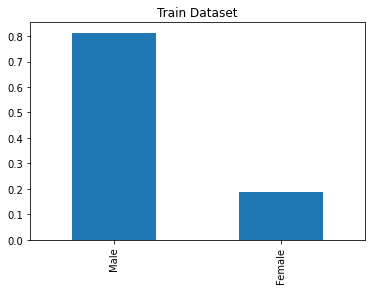

In [ ]:
ax1 = df_train['Gender'].value_counts(normalize=True).plot.bar(title='Train Dataset')
plt.show()

In [ ]:
# Since Majority of applicants are male, assigning the value male to missing values
df_train['Gender'] = df_train['Gender'].fillna("Male")

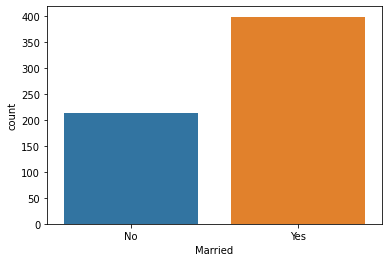

In [ ]:
sns.countplot(df_train['Married']);

In [ ]:
# Same thing with Married
df_train['Married'] = df_train['Married'].fillna("Yes")

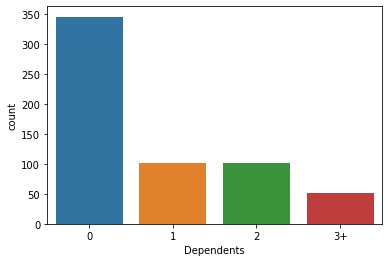

In [ ]:
sns.countplot(df_train['Dependents']);

In [ ]:
df_train['Dependents'] = df_train['Dependents'].fillna(0)

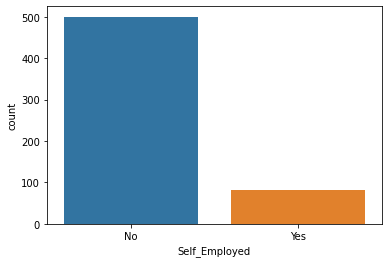

In [ ]:
sns.countplot(df_train['Self_Employed']);

In [ ]:
df_train['Self_Employed'] = df_train['Self_Employed'].fillna('No')

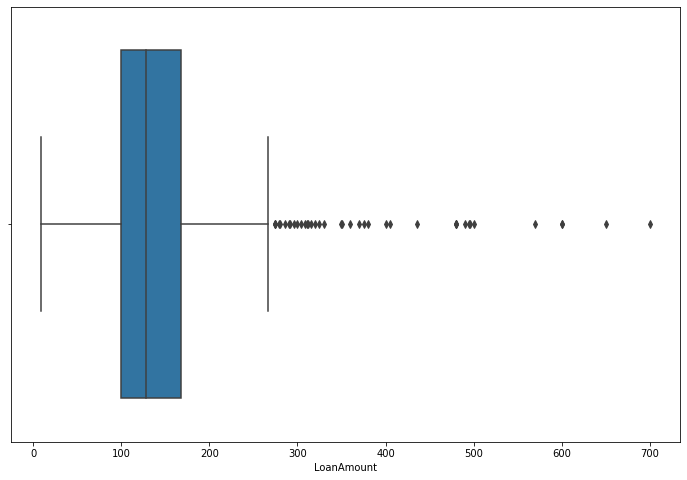

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(df_train['LoanAmount']);
df_train['LoanAmount']= df_train['LoanAmount'].fillna(150)

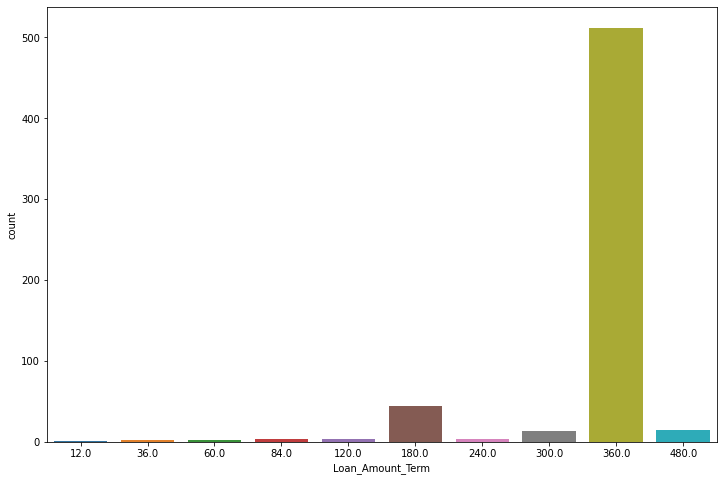

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(df_train['Loan_Amount_Term']);

In [ ]:
df_train['Loan_Amount_Term']= df_train['Loan_Amount_Term'].fillna(360)

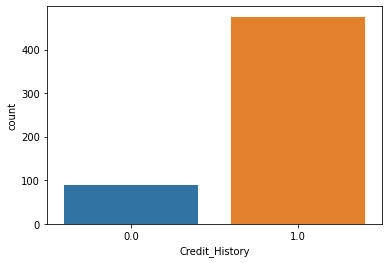

In [ ]:
sns.countplot(df_train['Credit_History']);

In [ ]:
df_train['Credit_History'] = df_train['Credit_History'].fillna(1.0)

In [ ]:
## Confirming whether all the null values are filled or not
df_train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Converting Categorical Variables/Strings to Integer

In [ ]:
df_unique = df_train.nunique()
df_unique

Loan_ID              614
Gender                 2
Married                2
Dependents             5
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [ ]:
#Binary variables
binary_variable = list(df_unique[df_unique==2].index)
binary_variable

['Gender',
 'Married',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Loan_Status']

In [ ]:
#categorical variables with multiple categories that is greater than 2 (binary)
categorical_variables = list(df_unique[(df_unique>2)&(df_unique <=6)].index)
df_train[categorical_variables].nunique()

Dependents       5
Property_Area    3
dtype: int64

In [ ]:
df_train['Gender'] = df_train['Gender'].replace(['Male','Female'],[1,0])
df_train['Married'] = df_train['Married'].replace(['Yes','No'],[1,0])
df_train['Dependents'] = df_train['Dependents'].replace(['0','1','2'],[0,1,2])
df_train['Dependents'] = df_train['Dependents'].replace('3+' , 3)
df_train['Education'] = df_train['Education'].replace(['Graduate' , 'Not Graduate'],[1,0])
df_train['Self_Employed'] = df_train['Self_Employed'].replace(['Yes','No'],[1,0])
df_train['Property_Area'] = df_train['Property_Area'].replace(['Urban' ,'Rural' ,'Semiurban'],[0,1,2])
df_train['Loan_Status'] = df_train['Loan_Status'].replace(['Y','N'],[1,0])

### Splitting the Train dataset into train and dev dataset

In [ ]:
X = df_train.drop(columns=['Loan_Status', 'Loan_ID'], axis=1)
y = df_train['Loan_Status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest Hyperparameter Tuning using Grid Search CV

In [ ]:
#Number of trees in RF
n_estimators = [15, 20, 30, 50, 75, 100, 200, 300, 400]
#Number of features to consider at each split
max_features = ['auto', 'sqrt']
#maximum number of level in the tree
max_depth =[1,2,4]
#Selecting samples for each tree
bootstrap = [True, False]
#Minimum number of samples required at each node
min_samples_leaf = [1,2,3]
#Splitting with either entropy or gini
criterion=['gini','entropy']

param_grid ={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap,
             'criterion':criterion}


RF = RandomForestClassifier(oob_score=True, warm_start=True, n_jobs=-1)

GRF = GridSearchCV(estimator=RF,
    param_grid=param_grid,
    scoring=None,
    n_jobs=-1,
    cv=4)

GRF.fit(X_train,y_train)
predGRF = GRF.predict(X_test)

In [ ]:
GRF.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 50}

In [ ]:
print(classification_report(y_test, predGRF))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



## Decision Tree HyperParameter Tuning and Feature Importance

In [ ]:
DT = DecisionTreeClassifier().fit(X_train,y_train)

params_grid = {'max_depth':range(1, DT.tree_.max_depth+1, 2),
               'max_features':range(1,len(DT.feature_importances_)+1)
              }

DT_GV = GridSearchCV(DecisionTreeClassifier(random_state=101),
                   param_grid=params_grid,
                   scoring='accuracy',
                   n_jobs=-1)

DT_GV = DT_GV.fit(X_train,y_train)
y_predDT = DT_GV.predict(X_test)
DT_GV.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=101, splitter='best')

[Text(0, 0.5, 'Relative_Importance')]

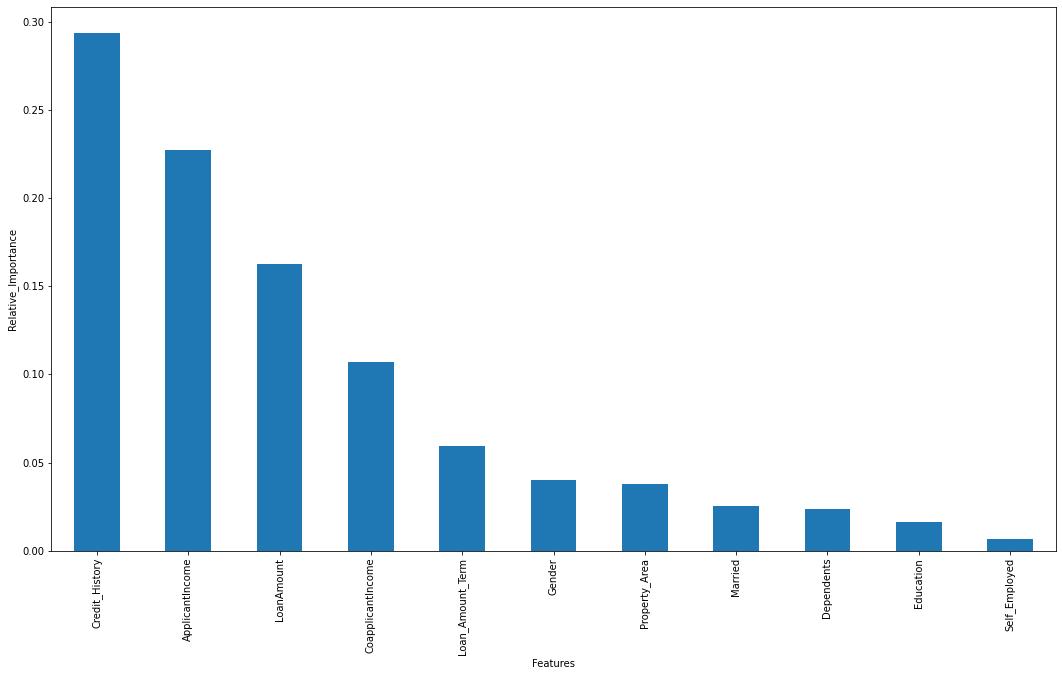

In [ ]:
Feature_importance = pd.Series(DT.feature_importances_, index=[x for x in X]).sort_values(ascending=False)
bar = Feature_importance.plot(kind='bar', figsize=(18,10))
bar.set(xlabel='Features')
bar.set(ylabel='Relative_Importance')

## Adaboost HyperParameter Tuning Using GridSearchCV

In [ ]:
parameters = {
              'learning_rate': [ 2, 1, 0.5, 0.2, 0.1, 0.01, 0.001],
              'n_estimators':[15, 20, 30, 40, 80, 100, 200, 400,500]
             }

AB = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='accuracy', n_jobs=-1)

AB = AB.fit(X_train,y_train)

y_predAB = AB.predict(X_test)

AB.best_params_

{'learning_rate': 2, 'n_estimators': 15}

In this week we have Tuned the Hyperparameters of the best performing Classifiers using feature selection and Grid Search CV.

In the next week, we will be improving further upon this using a method called Stacking or Bagging in another words.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Feature selection through Forward Step
sfs = SFS(RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
          k_features=10, 
          forward=False,
          floating= False,
          verbose = 2,
          scoring='accuracy',
          cv=2,
          n_jobs=-1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.8s finished

[2021-07-25 16:51:55] Features: 10/10 -- score: 0.8146507383441182

## Best score of this week is 81.46 which has exceeded past week's performance by 1%